# Определение возраста покупателей

Заказчик предоставил датасет с фотографиями людей и данными об их примерном возрасте.

Необходимо построить и обучить свёрточную нейронную сеть, определяющую возраст по представленной фотографии человека.

Построенная модель будет использована для:
* Анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
* Контроля добросовестности кассиров при продаже алкоголя.

Критерием успешности является значение MAE на тестовой выборке не больше 8.


Вид задачи: CV, классификация

Технологии: pandas, seaborn, keras/tensorflow, ResNet50, Adam, генераторы, облачные вычисления на GPU

Подходы: аугментация

## Исследовательский анализ данных

Проведём исследовательский анализ данных:
* Посмотрим на размер выборки.
* Построим график распределения возраста в выборке.
* Напечатаем на экране несколько фотографий и посмотрим, как устроен датасет.

На основе полученных данных сделаем выводы о том, как выявленные особенности повлияют на обучение модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv') # с двумя колонками: file_name и real_age
display(df.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
display(df.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Грубой рекомендацией при классификации на CNN-сетях является 1000 объектов данных на один класс. В отношении регрессии требования могут быть проще, тем не менее, проведём аугментацию датасета с помощью горизонтального зеркалирования. Так как речь идёт о распознавании лиц, ценность использования иных способов аугментации не очевидна.

In [5]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(16,10), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """

    sns.set(font_scale=font_scale)
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    sns.boxplot(x=data, ax=ax_box2)
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    if xlabel: ax_hist2.set(xlabel=xlabel)
    if title: ax_box2.set(title=title)
    plt.show()

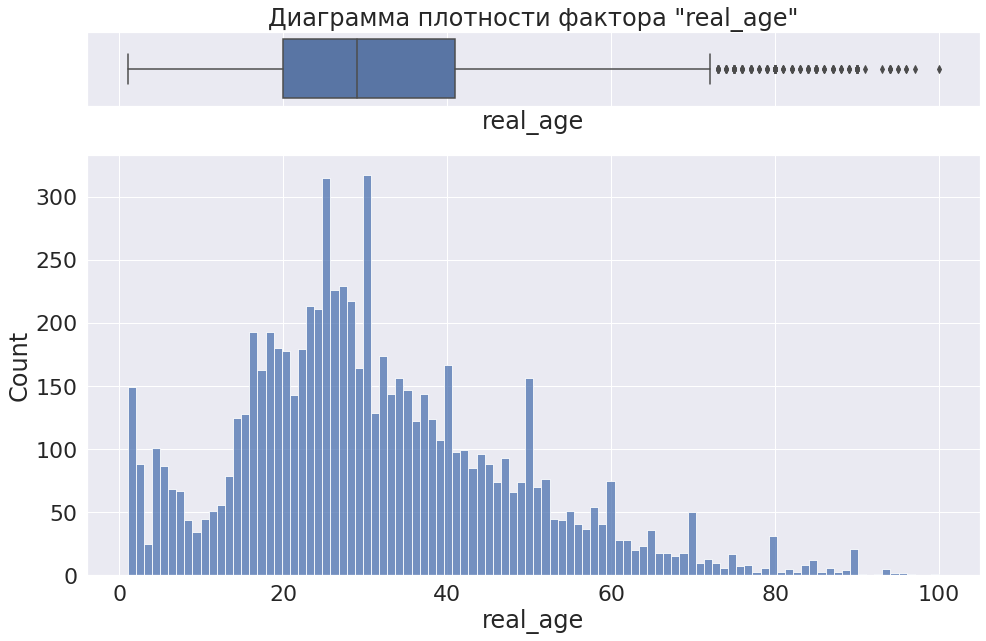

In [6]:
column = 'real_age'
histogram_boxplot(df[column], bins = 100, title=f'Диаграмма плотности фактора "{column}"', xlabel=column)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)
print(features.shape)
print(target.shape)

(32, 224, 224, 3)
(32,)


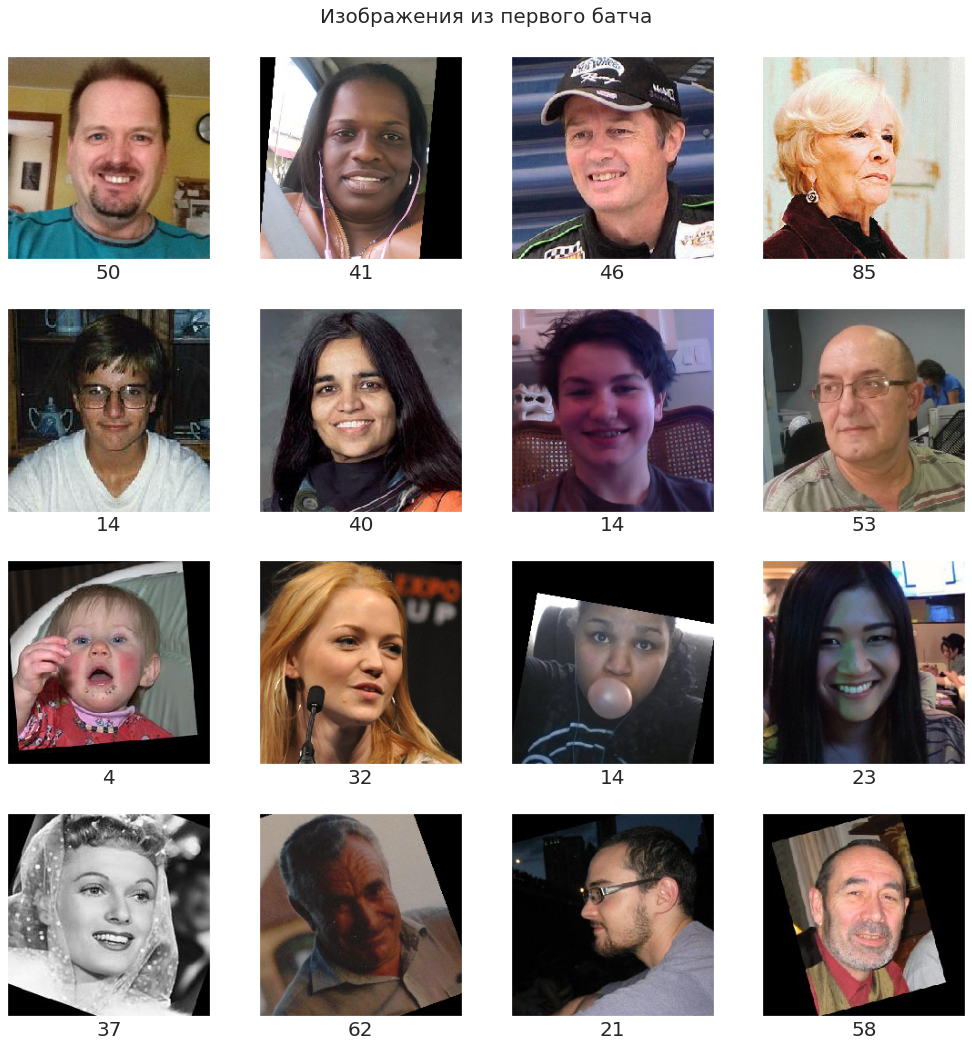

In [9]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Изображения из первого батча', fontsize=20)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    ax.set_xlabel(target[i], fontsize=20)

Выводы:
* Датасет максимально покрывает диапазон возрастов от 20 до 40 лет. В диапазонах 0-19 и 41+ также представленность хуже и сильно падает с возрастом.
* Пиковые значения на "круглых" значениях возраста наводят на мысли, что возраст для таких фото указывался примерный.
* На фото представлены люди разных рас.
* Фото не выровнены по подаче: есть цветные в разных палитрах и ч/б, чёткие и с низкой детализацией.
* Часть фото искажены вращением с добавлением чёрного фона.
* Лица на датасете имеют разную направленность по отношению к камере. Этот вопрос стоит исследовать подробней в основной части проекта.
* Часть изображений вызывает вопросы в плане классификации: например, фигура человека на фоне природы или удалённое и повёрнутое изображение ребёнка. Полагаем, что по таким изображениям определить возраст проблематично: не видно лица и выводы модели могут быть сделаны по контексту или иным неявным факторам.

## Обучение модели

Ниже приведён код обучения модели и результат вывода на экран в процессе обучения.


(Код в этом разделе запускался в отдельном GPU-блокноте, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    #vertical_flip=True,
    #horizontal_flip=True,
    #rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='training',
                                                     seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/', 
                                                     x_col='file_name',
                                                     y_col='real_age', 
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw', 
                                                     subset='validation',
                                                     seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        #weights='imagenet',
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
# < результат вывода на экран >

Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/6
356/356 - 68s - loss: 216.5961 - mae: 10.5424 - val_loss: 501.5891 - val_mae: 17.2529
Epoch 2/6
Epoch 3/6
356/356 - 46s - loss: 84.6548 - mae: 6.9668 - val_loss: 129.4600 - val_mae: 8.6234
356/356 - 57s - loss: 59.9689 - mae: 5.9125 - val_loss: 95.4878 - val_mae: 7.5916
Epoch 4/6
356/356 - 72s - loss: 44.3954 - mae: 5.0722 - val_loss: 74.1727 - val_mae: 6.4939
Epoch 5/6
356/356 - 75s - loss: 32.4609 - mae: 4.3422 - val_loss: 68.5838 - val_mae: 6.1719
Epoch 6/6
356/356 - 67s - loss: 24.0890 - mae: 3.7700 - val_loss: 78.5184 - val_mae: 6.4447
119/119 - 12s - loss: 78.5184 - mae: 6.4447
Test MAE: 6.4447

```

## Анализ обученной модели

В работе использована 50-слойная предобученная нейросеть с архитектурой ResNet.
Для решения задачи регрессии последний полносвязный слой был замещён на слой с одним нейроном.

Для повышения качества модели (достижения целевой метрики качества) использовались следующие подходы:
* В последнем полносвязном слое использована функция активации ReLU.
* Использован алгоритм оптимизации Adam со сниженным шагом скорости обучения (lr=0.0001) и изменяющимся градиентом спуска.
* Выборка аугментировалась: изображения зеркалировались горизонтально.
* Увеличено количества эпох обучения до 6.


Итоговая модель демонстрирует MAE = 6.44 и преодолевает заданный заданием порог в 8 лет.

Задание оценки возраста покупателей имеет две практических составляющих:
* Рекомендации для допродажи продуктов, котоыре могли бы быть интересны данной категории покупателей. При этом, очевидно, что задача регрессии в бизнес-процессе будет неоптимальна: можно выделить диапазоны покупателей по диапазонами или кластерам (возрастным группам) и решать задачу классификации по нескольким классам.
* Контроль возраста при продаже регулируемых классов продуктов (например -- алкоголя). В данном случае, в основном процессе модель вряд ли будет более полезной по сравнению с обычной визуальной оценкой и контролем документов. Оцифровка предъявления документов также может помочь, но это отдельный большой проект. Тем не менее, в текущем виде модель может помечать "сомнительные" случаи продажи регулируемых товаров, что позволит анализировать записи с камер, данные о покупателе из программы лояльности.

Для получения меньшего разброса оценки возраста (вне данного проекта) стоит проанализировать следующие направления:
* Привести изображения к единой цветности
* Восстановить или убрать повёрнутые изображения с чёрным фоном
* Выделить изображения без лица или с малой его представленностью. Если таких изображений много и они могут поступать на вход модели, потребуется автоматическая классификация и отсев изображений как предварительный этап пайплайна.
* Проанализировать распределение целевого признака, дополнить малопредставленные значения
* Проанализировать пики на "красивых" возрастах
* Проанализировать ошибки модели на разных диапазонах возрастов